# Pruning Basics — Dense vs Zeroed-Out vs Structured (Step by Step)

This notebook refers to section **“Technical Details behind Pruning”**.  
Its main goals are to show why:

- Setting weights to zero (unstructured pruning *without* removal) **does not speed up** matrix multiplication on a regular CPU.
- Removing entire structures (structured pruning) **does** reduce compute and latency, because the **shapes actually shrink**.
- Gains from zeros require **sparse-aware kernels** or specialized backends.

**Audience:** beginners (no prior ML code required).  
**You’ll learn:** how matrix shape vs. zeros impacts runtime; what “structured vs. unstructured” means in practice.


## 0) How to use this notebook

- Keep the **default parameters** for a quick live demo.  
- If you increase matrix sizes (e.g., `1024`), the effect is more visible but takes longer.  
- Each experiment prints both the **shape** and the **time** so the audience sees *what changed* and *what did not*.

**Recommended defaults for live talk**  
- Shapes: `m=k=n=512` or `2048`.  
- Sparsity: `0.95` (zeros for the “zeroed‑out” demo).  
- Repetitions (`reps`): `50` (stabilizes timing).  
- Keep ratio (`keep_ratio`): `0.50` (structured pruning removes ~50% inner dimension).

In [1]:
import numpy as np, time

# Reproducibility
np.random.seed(42)

# --- Demo parameters (safe defaults) ---
m, k, n = 2048, 2048, 2048    # matrix sizes for A (m x k) and B (k x n)
sparsity = 0.95               # 95% of elements set to zero in the "zeroed-out" experiment
reps = 50                     # loop repetitions to amplify the timing effect on CPU
keep_ratio = 0.50             # 50% columns/rows kept for structured pruning

dtype = np.float32            # use float32 to keep memory and time reasonable

print(f"Parameters -> m={m}, k={k}, n={n}, sparsity={sparsity}, reps={reps}, keep_ratio={keep_ratio}, dtype={dtype}")

Parameters -> m=2048, k=2048, n=2048, sparsity=0.95, reps=50, keep_ratio=0.5, dtype=<class 'numpy.float32'>


## 1) Helper: tiny timing wrapper
We use a very small wrapper so timing printouts are consistent (same function across experiments).

In [2]:
def time_matmul(A: np.ndarray, B: np.ndarray, repeat: int = 50):
    """Time A @ B using a naive loop to repeat the same op many times.
    Returns the SUM of times (s) and the resulting shape.
    """
    times = []
    for _ in range(repeat):
        C = None
        t0 = time.perf_counter()
        C = A @ B
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return np.sum(times), C.shape

## 2) Experiment 1 — **Dense baseline** (no pruning)

**Goal:** establish a baseline with standard dense matrices.  
- We create `A` and `B` with random numbers.  
- We multiply once, then repeat the multiplication `reps` times to see a stable timing.  
- Shapes do **not** change.


In [3]:
# Dense baseline (no zeros)
A_dense = np.random.rand(m, k).astype(dtype)
B_dense = np.random.rand(k, n).astype(dtype)

In [4]:
t_dense, shapeC = time_matmul(A_dense, B_dense, repeat=50)
print(f"[Dense] Total over 50 runs -> time: {t_dense:.4f}s | C.shape = {shapeC}")

[Dense] Total over 50 runs -> time: 9.7691s | C.shape = (2048, 2048)


## 3) Experiment 2 — **Zeroed-out / Unstructured pruning** (no removal)

**Goal:** simulate unstructured pruning by setting many elements to zero, **without** shrinking shapes.

**Key point:** on a CPU, standard dense BLAS still treats these arrays as **dense**.  
Even with 80–95% zeros, you still compute `A(m×k) @ B(k×n)` touching similar memory layouts.  
**Result:** timing is often very close to the dense baseline.

We also print the **effective sparsity** (how many zeros you actually got).

In [5]:
# Create random masks to "prune" elements to zero (unstructured)
maskA = (np.random.rand(m, k) > sparsity).astype(dtype)   # True (~1.0) where we keep values
maskB = (np.random.rand(k, n) > sparsity).astype(dtype)

A_zeroed = A_dense * maskA
B_zeroed = B_dense * maskB

eff_sparsity_A = 1.0 - (np.count_nonzero(A_zeroed) / A_zeroed.size)
eff_sparsity_B = 1.0 - (np.count_nonzero(B_zeroed) / B_zeroed.size)

print(f"Effective sparsity -> A: {eff_sparsity_A:.2%} | B: {eff_sparsity_B:.2%}")
print(f"Shapes -> A_zeroed: {A_zeroed.shape} | B_zeroed: {B_zeroed.shape}")

# Zeroed-out baseline (50 runs, total time)
t_zero, shapeCz = time_matmul(A_zeroed, B_zeroed, repeat=50)
print(f"[Zeroed-out] Total over 50 runs -> time: {t_zero:.4f}s | Cz.shape = {shapeCz}")

Effective sparsity -> A: 95.01% | B: 95.01%
Shapes -> A_zeroed: (2048, 2048) | B_zeroed: (2048, 2048)
[Zeroed-out] Total over 50 runs -> time: 10.0349s | Cz.shape = (2048, 2048)


**Takeaway:**  
- The arrays have **the same shapes** as the dense baseline, so the BLAS kernel still runs a dense GEMM.  
- Zeros do not magically remove work on CPU.  
- Real speedups from unstructured sparsity need **sparse kernels** or a backend that understands this layout (GPU vendor libs, or frameworks with sparse ops).  
- For teaching: *“Zeros alone do not help the CPU; you need removal or sparse-aware kernels.”*


## 4) Experiment 3 — **Structured pruning** (actual removal)

**Goal:** remove entire columns in `A` and the matching rows in `B`.  
This reduces the inner dimension from `k` to `k_reduced = int(k * keep_ratio)`.

**Why this matters:** the **shape shrinks**, so the math cost goes down.  
You should see **lower time** compared to the dense baseline.


In [6]:
# Pick a subset of columns/rows to keep (structured pruning)
k_reduced = int(k * keep_ratio)
idx_keep = np.random.choice(k, size=k_reduced, replace=False)
idx_keep.sort()

A_struct = A_dense[:, idx_keep]    # (m, k_reduced)
B_struct = B_dense[idx_keep, :]    # (k_reduced, n)

print(f"Shapes -> A_struct: {A_struct.shape} | B_struct: {B_struct.shape}")

# Structured baseline (50 runs, total time)
t_struct, shapeCs = time_matmul(A_struct, B_struct, repeat=50)
print(f"[Structured] Total over 50 runs -> time: {t_struct:.4f}s | Cs.shape = {shapeCs}")

# Theoretical compute drop (very rough): proportional to inner dimension
print(f"Approximate compute drop vs dense baseline: k_reduced/k = {k_reduced/k:.2f} (~{100*(1-k_reduced/k):.0f}% fewer MACs on the inner dimension)")

Shapes -> A_struct: (2048, 1024) | B_struct: (1024, 2048)
[Structured] Total over 50 runs -> time: 5.3923s | Cs.shape = (2048, 2048)
Approximate compute drop vs dense baseline: k_reduced/k = 0.50 (~50% fewer MACs on the inner dimension)


## 5) Experiment 4 — Sparse acceleration (with SciPy)

**Goal:** show that when we use a *sparse-aware* library, zeros finally help.  
- Convert the zeroed-out matrices into CSR format (`csr_matrix`).  
- Multiply them and compare time with the dense version.  
- Key idea: “Zeros alone don’t help in NumPy, but sparse libraries can exploit them.”

In [7]:
from scipy.sparse import csr_matrix

# Build CSR once from the existing zeroed-out matrices (conversion OUTSIDE timers)
A_csr = csr_matrix(A_zeroed)
B_csr = csr_matrix(B_zeroed)

# Sparse (CSR @ CSR) — 50 runs, total time (same function as others)
t_sparse_csr, _ = time_matmul(A_csr, B_csr, repeat=50)
print(f"[Sparse (CSR@CSR)] Total over 50 runs -> time: {t_sparse_csr:.4f}s")

[Sparse (CSR@CSR)] Total over 50 runs -> time: 7.7801s


## 6) Timing comparison charts

Let's generate **visual comparisons** of execution time with two bar charts:
1) **Single multiply**, and  
2) **Loop × `reps`** (repeated multiplies for a more stable timing).

In both charts, the **dashed horizontal line** represents the **Dense baseline** (reference).  
The **bars** show the variants:
- **Zeroed-out** (same shapes, many zeros),
- **Structured** (reduced inner dimension),
- **Sparse (CSR)** — shown only if SciPy timings were collected.

**What to look for**
- **Zeroed-out ≈ Dense**: bars should be close to the line (no real CPU speedup).
- **Structured < Dense**: bars should drop below the line (fewer FLOPs → faster).
- **Sparse (CSR)** may be **< Dense** when sparsity is high and/or with CSR @ dense products.

**Axes & scale**
- **Y-axis:** time in seconds (auto-scaled with a small headroom to improve readability).
- **X-axis:** method variants for the chosen scenario (Single or Loop).

> **Run order reminder:** execute Experiments 1–3 (and 4 if applicable) **before** plotting, so all timing variables are defined.


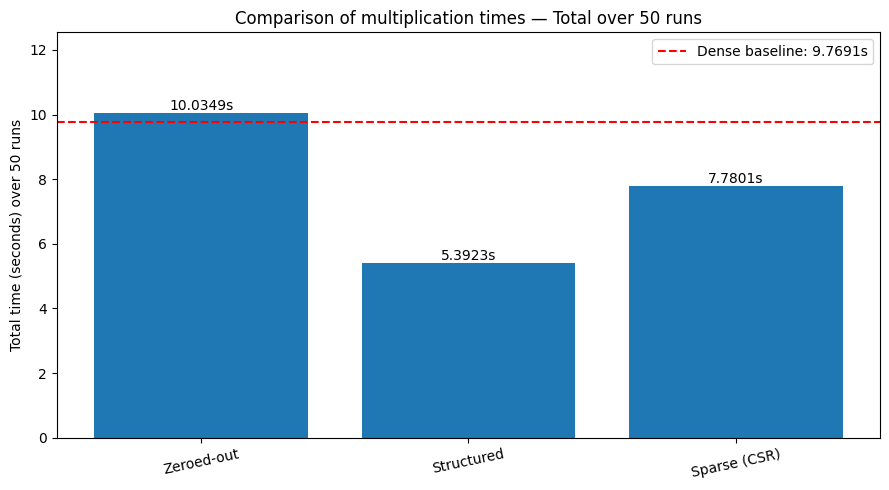

In [8]:
import matplotlib.pyplot as plt

# Chart: Total over 50 runs — bars vs Dense baseline line
labels = ["Zeroed-out", "Structured", "Sparse (CSR)"]
values = [t_zero, t_struct, t_sparse_csr]

ymax = max(values + [t_dense]) * 1.25

plt.figure(figsize=(9,5))
plt.bar(labels, values)

# Add horizontal line for Dense baseline
plt.axhline(y=t_dense, linestyle="--", color="red", label=f"Dense baseline: {t_dense:.4f}s")

plt.ylim(0, ymax)
plt.ylabel("Total time (seconds) over 50 runs")
plt.title("Comparison of multiplication times — Total over 50 runs")
plt.xticks(rotation=12)

# Add value labels on top of bars
for i, v in enumerate(values):
    plt.text(i, v, f"{v:.4f}s", ha="center", va="bottom")

plt.legend()
plt.tight_layout()
plt.show()


## 7) Key takeaways

- **Unstructured pruning with zeros:** shapes stay the same → dense kernels do the same amount of work on CPU → **no real speedup**.  
- **Structured pruning:** removes columns/rows/filters/layers → **shapes shrink** → fewer FLOPs and **lower latency** even on CPU.  
- **Sparse acceleration:** to benefit from zeros alone, you need **sparse-aware** libraries or specialized hardware.

> *“Zeroing values does not change the math; removing structures does.”*

---

$$\Huge \textbf{Part 2}$$

---


# Criteria for Selecting Structures — Hands-on (L1/L2/Geometric Mean)

This mini-lab shows **how to pick what to prune** in a neural network using **magnitude-based criteria**.
We will:
- create a tiny synthetic Conv layer,
- compute **per-filter** and **per-channel** scores (L1/L2/Geometric Mean of |W|),
- **rank** and **prune** the lowest p%,
- check **shapes** and a simple **FLOPs proxy** for expected speedup.

> Focus: **structured pruning** (filters/channels). After pruning, we typically do a short **fine-tune** (not run live).

## Parameters — quick guide

We’ll simulate a tiny Conv layer and use simple **magnitude criteria** (L1/L2/Geomean) to decide **what to prune**.

**What these knobs do**
- `NUM_FILTERS` → number of **output filters** (more = larger layer).
- `IN_CHANNELS` → number of **input channels** (e.g., RGB = 3).
- `KERNEL_H, KERNEL_W` → filter size (3×3 by default).
- `PRUNE_FRAC` → fraction of **filters** to remove (by the chosen criterion).
- `PRUNE_FRAC_CHANNEL` → fraction of **input channels per filter** to remove.

**How to run**
1) Keep defaults for a fast demo.  
2) Run top→down: create weights → compute scores → **rank** → **prune** → check shapes/FLOPs proxy.  
3) Interpretation: **smaller scores ⇒ prune first**; **structured pruning** (filters/channels) reduces shapes ⇒ expected speedup.

In [ ]:
import numpy as np, time
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)

NUM_FILTERS = 8
IN_CHANNELS = 3
KERNEL_H, KERNEL_W = 3, 3

PRUNE_FRAC = 0.25
PRUNE_FRAC_CHANNEL = 0.25

dtype = np.float32

print("[OK] Params loaded:",
      f"filters={NUM_FILTERS}, in_channels={IN_CHANNELS}, kernel={KERNEL_H}x{KERNEL_W},",
      f"prune_f={PRUNE_FRAC:.0%}, prune_fc={PRUNE_FRAC_CHANNEL:.0%}")

[OK] Params loaded: filters=8, in_channels=3, kernel=3x3, prune_f=25%, prune_fc=25%


## 1) Synthetic Conv weights

We create a small Conv weight tensor with shape `(out_filters, in_channels, kh, kw)`.  
This lets us compute **per-filter** and **per-channel** importance scores.

In [ ]:
F, Cin = NUM_FILTERS, IN_CHANNELS
Kh, Kw = KERNEL_H, KERNEL_W

# Random toy weights (no training; just for scoring demos)
W = (0.2 * np.random.randn(F, Cin, Kh, Kw)).astype(dtype)

print("W shape:", W.shape)
print("Example kernel W[0,0]:\n", W[0,0])

W shape: (8, 3, 3, 3)
Example kernel W[0,0]:
 [[ 0.35281047  0.08003144  0.1957476 ]
 [ 0.44817865  0.3735116  -0.19545558]
 [ 0.19001769 -0.03027144 -0.02064377]]


## 2) Criteria (magnitude-based)

We’ll score magnitude per structure:
- **L1** = sum(|W|)  
- **L2** = sqrt(sum(W²))  
- **Geometric mean of |W|** = exp(mean(log(|W|+eps)))

Interpretation: **smaller score ⇒ less important ⇒ prune first**.

In [ ]:
def l1_score(arr: np.ndarray) -> float:
    return float(np.linalg.norm(arr, ord=1))          # L1

def l2_score(arr: np.ndarray) -> float:
    return float(np.linalg.norm(arr))                 # L2 (ord=2 default)

def gmean_abs(arr: np.ndarray, eps: float = 1e-8) -> float:
    a = np.abs(arr) + eps
    return float(np.exp(np.log(a).mean()))            # geomean(|w|)

## 3) Per-filter scores (structured pruning at filter level)

Compute one score per **output filter** (collapse all other axes).  
We’ll tabulate **L1/L2/Geomean** and sort by **L1** (baseline choice).

In [ ]:
Wf = W.reshape(F, -1)

scores_filter = pd.DataFrame({
    "filter": np.arange(F),
    "L1": [l1_score(Wf[i]) for i in range(F)],
    "L2": [l2_score(Wf[i]) for i in range(F)],
    "GeometricMeanAbs": [gmean_abs(Wf[i]) for i in range(F)],
}).sort_values("L1", ascending=True).reset_index(drop=True)

print("Filters sorted by L1 (ascending) — candidates to prune on top:")
scores_filter

Filters sorted by L1 (ascending) — candidates to prune on top:


,filter,L1,L2,GeometricMeanAbs
0,2,3.265481,0.786908,0.079999
1,7,3.939165,0.934826,0.098799
2,6,4.461070,1.001864,0.118668
3,4,4.523472,1.041675,0.124894
4,5,4.630366,1.061562,0.130265
5,1,4.824330,1.104231,0.136262
6,0,4.910399,1.207496,0.118037
7,3,5.143628,1.154568,0.134698


## 4) Visual check — per-filter bars

Bar charts help spot consistently **small** filters across criteria.  
Lower bar ⇒ stronger prune candidate.

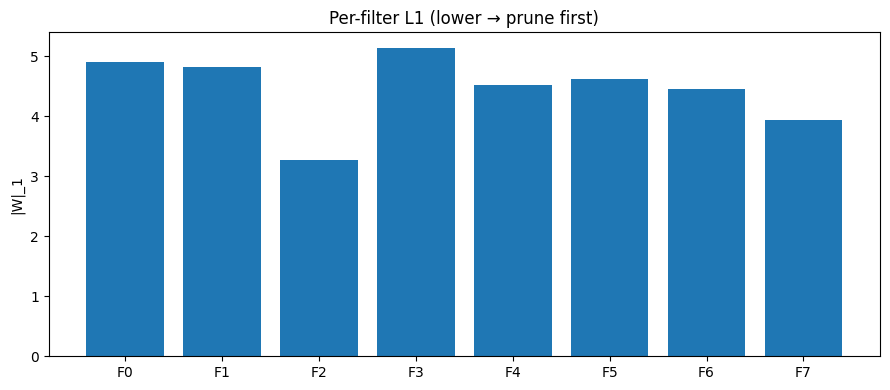

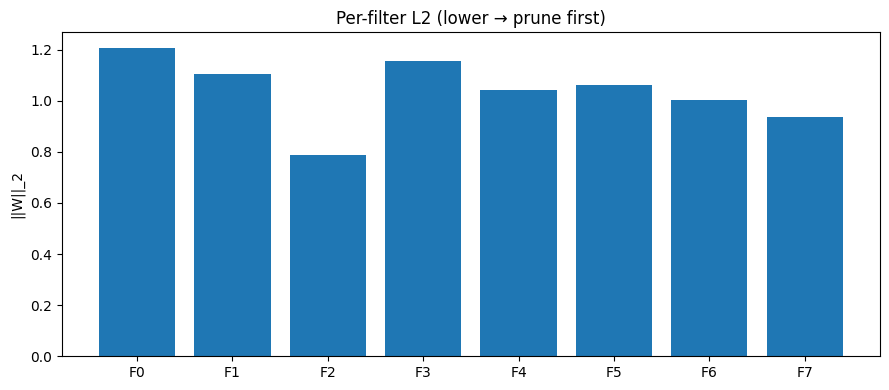

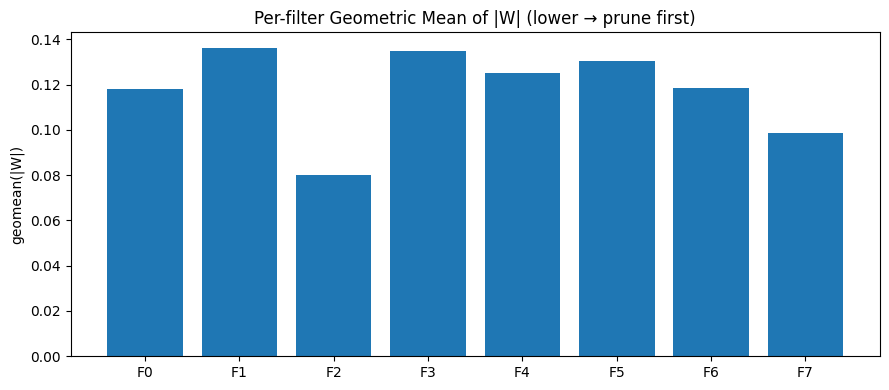

In [ ]:
labels = [f"F{i}" for i in range(F)]
scores_idx = scores_filter.set_index("filter").reindex(range(F))

L1_vals = scores_idx["L1"].values
L2_vals = scores_idx["L2"].values
GM_vals = scores_idx["GeometricMeanAbs"].values

plt.figure(figsize=(9,4))
plt.bar(labels, L1_vals)
plt.title("Per-filter L1 (lower → prune first)")
plt.ylabel("|W|_1")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
plt.bar(labels, L2_vals)
plt.title("Per-filter L2 (lower → prune first)")
plt.ylabel("||W||_2")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
plt.bar(labels, GM_vals)
plt.title("Per-filter Geometric Mean of |W| (lower → prune first)")
plt.ylabel("geomean(|W|)")
plt.tight_layout()
plt.show()

## 5) Select & prune filters (structured)

Prune the **lowest p%** filters by **L1** (you can switch to L2/Geomean).  
Structured pruning removes **whole filters** (output channels) ⇒ shapes shrink.

In [ ]:
K = max(1, int(PRUNE_FRAC * F))       # how many filters to remove
order_l1 = np.argsort(L1_vals)        # ascending by L1
to_prune_filters = order_l1[:K]
to_keep_filters  = np.setdiff1d(np.arange(F), to_prune_filters)

W_pruned_filters = W[to_keep_filters, :, :, :]

print("Criterion:", "L1 per filter")
print("Original W shape:", W.shape)
print("Pruned   W shape:", W_pruned_filters.shape)
print("Pruned filter indices:", to_prune_filters)

Criterion: L1 per filter
Original W shape: (8, 3, 3, 3)
Pruned   W shape: (6, 3, 3, 3)
Pruned filter indices: [2 7]


## 6) Per-channel scores (structured at input-channel level)

Sometimes we keep the number of **filters**, but prune **input channels**.  
We score each block `(filter, input_channel)` (here with **L1**) and prune the lowest p% **per filter**.

In [ ]:
L1_fc = np.zeros((F, Cin), dtype=np.float64)
for f in range(F):
    for c in range(Cin):
        L1_fc[f, c] = l1_score(W[f, c])

Kc = max(1, int(PRUNE_FRAC_CHANNEL * Cin))

keep_channels = []
pruned_channels = {}

for f in range(F):
    order = np.argsort(L1_fc[f])     # smallest first
    prune_c = order[:Kc]
    keep_c  = np.setdiff1d(np.arange(Cin), prune_c)
    pruned_channels[f] = prune_c
    keep_channels.append(keep_c)

# Ragged results: different #channels kept per filter
pruned_by_channel = [W[f, keep_channels[f], :, :] for f in range(F)]
shapes_after = [arr.shape for arr in pruned_by_channel]

print("Per-(filter, channel) L1 shape:", L1_fc.shape)
print("Example L1 scores for F0:", np.round(L1_fc[0], 6))
print("Channels pruned per filter:", pruned_channels)
print("Resulting shapes per filter (ragged):", shapes_after[:3], "...")

Per-(filter, channel) L1 shape: (8, 3)
Example L1 scores for F0: [0.991007 0.420659 0.668183]
Channels pruned per filter: {0: array([1]), 1: array([0]), 2: array([0]), 3: array([1]), 4: array([1]), 5: array([0]), 6: array([1]), 7: array([2])}
Resulting shapes per filter (ragged): [(2, 3, 3), (2, 3, 3), (2, 3, 3)] ...


## 7) FLOPs proxy & expected speedup (filters-only)

Rough rule for conv compute (ignoring spatial terms):  
`FLOPs ∝ F_out × C_in × K_h × K_w`.

Pruning **filters** lowers `F_out` ⇒ fewer operations.  
We estimate a before/after ratio and an approximate speedup.

In [ ]:
F_after = W_pruned_filters.shape[0]
Cin_after = Cin  # channel demo above is illustrative; we keep Cin fixed here

flops_before = F * Cin * Kh * Kw
flops_after  = F_after * Cin_after * Kh * Kw
ratio = flops_after / flops_before
speedup = (1.0 / ratio) if ratio > 0 else float("inf")

print(f"FLOPs proxy — before: {flops_before}, after: {flops_after}, ratio: {ratio:.2f}")
print(f"Approximate speedup (filters-only): {speedup:.2f}×")

FLOPs proxy — before: 216, after: 162, ratio: 0.75
Approximate speedup (filters-only): 1.33×


## 8) Optional — Fine-tuning after pruning

After structured pruning, we usually run a short **fine-tune** to recover accuracy:
- Freeze most layers; train only the **last layer** (or use **PEFT/LoRA**).
- Small LR (e.g., 5e-4), **1–2 epochs** on a **small subset**.
- Show precomputed “before/after” metrics rather than running live.

**Takeaway:** pruning gives the **efficiency**; a brief fine-tune **recovers most accuracy**.

## 9) Explore

- Change `PRUNE_FRAC` or `PRUNE_FRAC_CHANNEL` and re-run to see new prune sets.  
- Swap the criterion for pruning (L2 or Geomean).  
- Remember: **structured pruning** (filters/channels) reduces **shapes**, which is what enables **immediate compute/latency** gains.